# Monte Carlo Simulation Technique based on the work of (McCrickerd, Pakkanen, 2018)

In [1]:
import os
path_folder=r'C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi'
os.chdir(path_folder)

In [2]:
import datetime as datetime
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import cm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from utils import bsinv
from yahoo_fin.options import get_options_chain, get_expiration_dates

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import pickle
import pytz
import scipy
import scipy.stats as st
import warnings

vec_bsinv = np.vectorize(bsinv)
% matplotlib inline

UsageError: Line magic function `%` not found.


# The forward price

In [3]:
def forward_price(spot, div, r, tau):
    """
    Input:
    spot = Spot Price
    div = sum of dividends to be paid until expiration of option contract at T
    r = Risk free rate
    tau = Time to Expiration (can be single number or array)
    
    Output:
    Forward Price F
    
    Computes the forward price, allows for single or array input
    """
    
    F = spot*np.exp(r*tau) - div*np.exp(r*tau)
    return F

# rBergomi Model Simulation

In [4]:
def rbergomi_s(forward, strikes, texp, params):
    
    """
    Input: 
    forward = Forward Price
    strikes = Set of Strike prices for one(!) expiration
    texp = Time to Expiration
    params = rBergomi Parameters
    
    Output:
    rBivs = rBergomi IVs
    call_prices = rBergomi computed call prices
    rB = rBergomi model object
    FT = 20.000 Forward Price adjusted price realizations at T
    
    This function is able to compute the rBergomi IVs and other values for a single(!)
    expiration
    
    """
    
    alpha, eta, rho, xi = params
    
    # to ensure computation works, we have to give greater granularity for very short durations.
    if texp < 0.01:
        steps_year = 100000
    else:
        steps_year = 366

    # Defining the Fractional Brownian Process and Resulting Price Process
    np.random.seed(4)
    rB = rBergomi(n = steps_year, N = 20000, T = texp, a = alpha)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho = rho)
    V = rB.V(Y, xi = xi, eta = eta)
    S = rB.S(V, dB)
    
    # rBergomi Implied Volatilities and Call Prices
    ST = S[:,-1][:,np.newaxis]
    FT = ST*forward
    K = strikes #np.exp(strikes) #(np.exp(k)*spot)[np.newaxis,:]
    call_payoffs = np.maximum(FT - K,0)
    call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    rBivs = vec_bsinv(call_prices, forward, np.transpose([K]), rB.T)
    return rBivs, call_prices, rB, FT

# Defining some helper functions to combine all information and clean data

In [5]:
def calculating_expiration(file_name, expiration_dates, loaded_dictionary):
    """
    Input:
    file_name = file name of loaded option data in pickle format
    expiration_dates = extracted dates of maturities for option data 
    loaded_dictionary = all available option data
    
    Output:
    df_all_maturities = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Calculating all expirations of option chain in years and 
    combining all information into one DataFrame!
    """
    
    # Time of File
    date_str = file_name[17:-4]
    str_format1 = "%Y-%m-%d"
    t_datetime = datetime.datetime.strptime(date_str, str_format1)


    df_all_maturities = pd.DataFrame()
    for i, val in enumerate(expiration_dates):

        # Time To Expiration
        str_format2 = "%B %d, %Y"
        exp_datetime = datetime.datetime.strptime(val, str_format2)

        # Calculating Time to Expiration in Years
        totsec = (exp_datetime - t_datetime).total_seconds()
        years = totsec / 3600 / 24 / 365
        tau = np.round(years, 3)
        
        # Storing all info in the dataframe
        df_maturity_t = loaded_dictionary[val]["calls"]
        df_maturity_t["Maturity"] = val
        df_maturity_t["Tau"] = tau
        df_all_maturities = pd.concat([df_all_maturities, df_maturity_t])
    return df_all_maturities, t_datetime

def clean_contracts(df, t_datetime):
    """
    Input:
    df = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Output:
    df_clean = dataframe of cleaned data by liquidity and time of last trade
    df_unclean = dataframe with both liquid (clean) and illiquid (unclean) data
    
    Cleans the observed contracts according to liquidity and time of last price
    
    """
    
    df2 = df.copy()
    
    str_format2 = "%B %d, %Y"
    exp_datetime_list = [datetime.datetime.strptime(x, str_format2) for x in df2["Maturity"].values]
    
    # calculate needed data
    mid = (df2["Ask"] + df2["Bid"])/2
    spread = df2["Ask"] - df2["Bid"]
    liquidity = spread/mid
    df2["Mid"] = mid
    df2["Spread"] = spread
    df2["Liquidity"] = liquidity
    df2["Keep"] = True
    
    # Calculate forward price for all contracts
    fwd_list = forward_price(spot, div, r, df2["Tau"])
    df2.loc[:, "Fwd"] = fwd_list
    
    # Transform the reported IVs into usable float format
    yahoo_ivs = [np.float(x.split("%")[0])*0.01 for x in df2["Implied Volatility"].values]
    df2.loc[:, "Implied Volatility"] = yahoo_ivs
    
    # Translate reported date into python timestamp
    dt_str_list = [x.split(" ")[0] for x in df2["Last Trade Date"]]
    listasts = pd.DatetimeIndex(dt_str_list)
    df2["Last Trade Date"] = listasts
    df2 = df2.reset_index(drop=True)
    
    # Iterate through the df
    for index, row in df2.iterrows():

        # Identify too old trades/quotes
        date = row["Last Trade Date"]
        lasttrade_delta = (t_datetime - date).days
        if lasttrade_delta >= 1: # if last trade is older than 1 day

            delta_percent = lasttrade_delta/(exp_datetime_list[index] - date).days
            #print("need to check: ", lasttrade_delta)
            #print("delta: ", delta_percent)
            if delta_percent > 0.05:
                keep_var = False
            else:
                keep_var = True

        else:
            keep_var = True
            
        if keep_var == True:
            # Identify illiquid option contracts, for all that have been traded recently
            
            liquidity_i = row["Liquidity"]
            #print(liquidity_i)
            #print("liquidity: ", liquidity_i)
            if liquidity_i > 0.05 or liquidity_i < 0:
                keep_var = False
                #print("Keep?", keep_var)
            else:
                keep_var = True
                
            #print(liquidity_i, keep_var)
        df2.loc[index,"Keep"] = keep_var
        

    df_unclean = df2
    #display(df_clean_test)

    df_clean = df_unclean[df_unclean["Keep"]==True]
    #display(df_clean_test) 
    
    cleaned_num = len(df) - len(df_clean)
    print("Number of deleted contracts: ", cleaned_num)
    return df_clean, df_unclean

# Reading in Data

In [6]:
file_name =  "optionsData_AAPL_2021-06-25.pkl" #"optionsData_AAPL_2021-05-05.pkl"
# Time of File
date_str = file_name[17:-4]
str_format1 = "%Y-%m-%d"
t_datetime = datetime.datetime.strptime(date_str, str_format1)

ticker_str = file_name[12:16]
file_to_read = open(file_name, "rb")
loaded_dictionary = pickle.load(file_to_read)
expiration_dates = [key for key in loaded_dictionary]

# Preparing Data

In [7]:
# Download Discount Rate for black scholes models
start = dt(2010, 1, 1)
end = dt.today()
# DFF = https://fred.stlouisfed.org/series/DFF
# Effective federal funds rate
eff = web.DataReader("DFF", "fred", start, end) # in percent
r = eff.loc[date_str].DFF * 0.01 # in decimal places

In [8]:
# Dividend
div = 0

# Spot price
spot = 133.11

In [112]:
"""
Here we calculate 
- the dataframe of only illiquid contracts
- BID/ASK/MID IVs
- Log Strike
- Log Moneyness

"""


# Combining all contracts for all maturities into one df
df_all_maturities, t_datetime = calculating_expiration(file_name, expiration_dates, loaded_dictionary)
# Cleaning the contracts
df_cleaned, df_uncleaned = clean_contracts(df_all_maturities, t_datetime)
# Dataframe of discarded option contracts
df_not_clean = df_uncleaned[~df_uncleaned.apply(tuple,1).isin(df_cleaned.apply(tuple,1))]

# As python is not able to compute the IVs within the functions above (potential bug?)
# we simply add those here:

# Finding BID/ASK/MID IVs for all contracts
bid_iv_vals = vec_bsinv(df_cleaned["Bid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
ask_iv_vals = vec_bsinv(df_cleaned["Ask"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
mid_iv_vals = vec_bsinv(df_cleaned["Mid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])

df_cleaned.loc[:, "Bid IVs"] = bid_iv_vals
df_cleaned.loc[:, "Ask IVs"] = ask_iv_vals
df_cleaned.loc[:, "Mid IVs"] = mid_iv_vals

# ------------------- This step is to take the yahoo reported IVs, whenever the MID IVs report erroneous values --------------------------------------------
mid_vols = df_cleaned["Mid IVs"].values
# This is a 1D array of true/false values given the condition at the end
condition=np.mod(mid_vols, 1)==1e-19
#this extracts the values from yahooivs, where mid-vols are close to zero
extractedvals = np.extract(condition, df_cleaned["Implied Volatility"].values)
# this inserts the yahoo ivs, in case the mid vols are close to zero in the correct position
np.place(mid_vols, mid_vols == 1e-19, extractedvals)

df_cleaned["Mid IVs"] = mid_vols
# ----------------------------------------------------------------------------------------------------------------------------------------------------------



# set log-strike column
log_strike = np.log(df_cleaned["Strike"]/df_cleaned["Fwd"])
df_cleaned.loc[:, "Log Strike"] = log_strike

# set log-moneyness column
log_moneyness = np.log(df_cleaned["Fwd"]/df_cleaned["Strike"])
df_cleaned.loc[:, "Log Moneyness"] = log_moneyness

Number of deleted contracts:  464


<ipython-input-112-fd7461024fe3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Mid IVs"] = mid_vols


In [18]:
# List of Option Maturities
expiration_dates

['July 2, 2021',
 'July 9, 2021',
 'July 16, 2021',
 'July 23, 2021',
 'July 30, 2021',
 'August 20, 2021',
 'September 17, 2021',
 'October 15, 2021',
 'November 19, 2021',
 'December 17, 2021',
 'January 21, 2022',
 'June 17, 2022',
 'September 16, 2022',
 'January 20, 2023',
 'March 17, 2023',
 'June 16, 2023']

In [107]:
# Singling out the option chain based on maturity with longest time to maturity
df_last_mat = df_cleaned[df_cleaned["Tau"]==1.975]
df_last_mat.iloc[:,5:]

,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau,Mid,Spread,Liquidity,Keep,Fwd,Bid IVs,Ask IVs,Mid IVs,Log Strike,Log Moneyness
921,74.35,-0.77,-1.03%,8,2218,0.3696,"June 16, 2023",1.975,74.150,0.40,0.005394,True,133.373152,0.317892,0.352443,0.336415,-0.798806,0.798806
922,69.70,-0.6,-0.85%,11,1616,0.3574,"June 16, 2023",1.975,69.500,0.40,0.005755,True,133.373152,0.317706,0.343744,0.331322,-0.718764,0.718764
923,65.15,-0.25,-0.38%,6,440,0.3473,"June 16, 2023",1.975,64.950,0.40,0.006159,True,133.373152,0.315920,0.336313,0.326423,-0.644656,0.644656
924,60.75,-0.36,-0.59%,7,462,0.3401,"June 16, 2023",1.975,60.525,0.45,0.007435,True,133.373152,0.312712,0.331213,0.322171,-0.575663,0.575663
925,56.40,0,-,3,798,0.3312,"June 16, 2023",1.975,56.175,0.45,0.008011,True,133.373152,0.308315,0.323762,0.316159,-0.511124,0.511124
926,52.20,-0.55,-1.05%,4,403,0.3238,"June 16, 2023",1.975,51.975,0.45,0.008658,True,133.373152,0.304417,0.317552,0.311055,-0.450500,0.450500
927,48.10,-0.32,-0.67%,3,586,0.3160,"June 16, 2023",1.975,47.900,0.40,0.008351,True,133.373152,0.300544,0.310680,0.305645,-0.393341,0.393341
928,44.25,-0.3,-0.67%,5,225,0.3111,"June 16, 2023",1.975,44.050,0.40,0.009081,True,133.373152,0.297603,0.306525,0.302083,-0.339274,0.339274
929,40.65,-0.4,-0.99%,29,8033,0.3081,"June 16, 2023",1.975,40.450,0.40,0.009889,True,133.373152,0.296137,0.304112,0.300136,-0.287981,0.287981
930,37.10,-0.45,-1.20%,102,603,0.3027,"June 16, 2023",1.975,36.900,0.40,0.010840,True,133.373152,0.291988,0.299259,0.295630,-0.239191,0.239191


# Manual Calibration

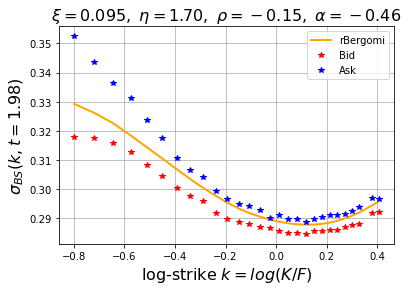

In [21]:
"""
Here we want to calibrate manually to the selected option chain above

"""

# Standard Parameters
#T = 1.0
a = -0.43
eta = 1.9
rho = -0.9
xi = 0.235**2


# Manual Calibrated Parameters for Fractional Brownian Process
# 26.06.2021
a_2 = -0.46
eta_2 = 1.7
rho_2 = -0.15
xi_2 = 0.309**2


params = a, eta, rho, xi
params_2 = a_2, eta_2, rho_2, xi_2
#rBivs, c0, rB, FT = rbergomi_s(forward, strike, tau, params)
rBivs, c0, rB, FT = rbergomi_s(df_last_mat["Fwd"].iloc[0], df_last_mat["Strike"].values, df_last_mat["Tau"].iloc[0], params_2)


# Graphing
plot, axes = plt.subplots()
axes.plot(df_last_mat["Log Strike"], rBivs, lw=2, c="orange", label="rBergomi")
#axes.plot(log_strike, implied_vols_orig_data, lw=2, alpha=0.6, c="purple", label="Original Data")
axes.plot(df_last_mat["Log Strike"], df_last_mat["Bid IVs"], "*", c="r", label = "Bid")
axes.plot(df_last_mat["Log Strike"], df_last_mat["Ask IVs"], "*", c="b", label="Ask")
#axes.plot(k_obs[idxT],iv_fit[idxT],'--g',label='Fit')
axes.legend()
axes.set_xlabel(r'log-strike $k=log(K/F)$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)

## Attempting Pricing using Black Scholes

In [22]:
df_last_mat_not_clean = df_not_clean[df_not_clean["Tau"]==1.975]
df_last_mat_not_clean

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau,Mid,Spread,Liquidity,Keep,Fwd
947,AAPL230616C00190000,2021-06-25,190.0,7.00,6.80,7.15,-0.09,-1.27%,49,904,0.2965,"June 16, 2023",1.975,6.975,0.35,0.050179,False,133.373152
950,AAPL230616C00210000,2021-06-25,210.0,4.80,4.70,5.05,-0.2,-4.00%,9,498,0.3019,"June 16, 2023",1.975,4.875,0.35,0.071795,False,133.373152
951,AAPL230616C00220000,2021-06-25,220.0,4.12,3.95,4.30,-0.23,-5.29%,3,229,0.3051,"June 16, 2023",1.975,4.125,0.35,0.084848,False,133.373152
952,AAPL230616C00230000,2021-06-25,230.0,3.51,3.35,3.65,-0.09,-2.50%,3,1745,0.3076,"June 16, 2023",1.975,3.500,0.30,0.085714,False,133.373152
953,AAPL230616C00240000,2021-06-25,240.0,3.10,2.91,3.20,0,-,1,1548,0.3121,"June 16, 2023",1.975,3.055,0.29,0.094926,False,133.373152
954,AAPL230616C00250000,2021-06-24,250.0,2.87,2.54,2.75,0,-,12,2182,0.3146,"June 16, 2023",1.975,2.645,0.21,0.079395,False,133.373152
955,AAPL230616C00260000,2021-06-25,260.0,2.45,2.30,2.47,0.02,+0.82%,181,4147,0.3199,"June 16, 2023",1.975,2.385,0.17,0.071279,False,133.373152


In [23]:
"""
Pricing Illiquid Options

"""

tau = df_last_mat_not_clean["Tau"].values[-1]
forward = forward_price(spot, div, r, tau)
strikes = df_last_mat_not_clean["Strike"].values
strikes = [*strikes, 40, 300]
rBivs_not_clean, c0_not_clean, rB_not_clean, FT_not_clean = rbergomi_s(forward, strikes, tau, params_2)

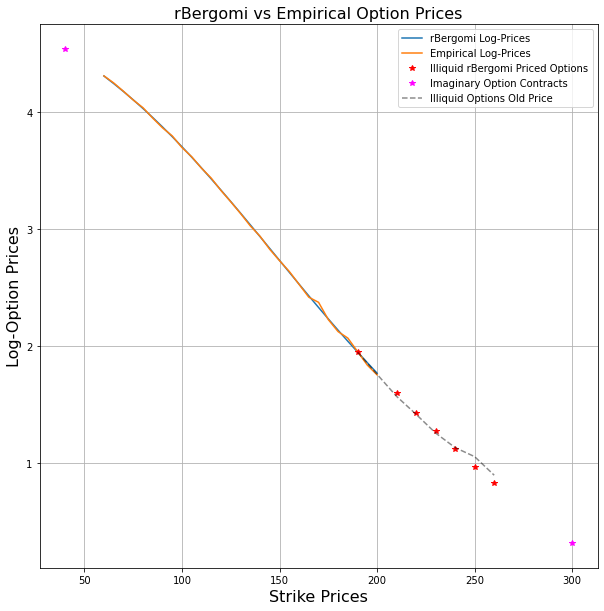

In [25]:
"""
Plotting Log-Option Prices: rBergomi prices VS Last Empirical trades
Also, we price illiquid (newly priced) and imaginary options  

"""


plot, axes = plt.subplots(figsize=(10,10))
axes.plot(df_last_mat["Strike"].values, np.log(np.squeeze(c0)), label="rBergomi Log-Prices")
axes.plot(df_last_mat["Strike"].values, np.log(df_last_mat["Last Price"].values), label="Empirical Log-Prices")
axes.plot(strikes[:-2], np.log(c0_not_clean[:-2]), "*", c="red", label="Illiquid rBergomi Priced Options")
axes.plot(strikes[-2:], np.log(c0_not_clean[-2:]), "*", c="magenta", label="Imaginary Option Contracts")
axes.plot(strikes[:-2], np.log(df_last_mat_not_clean["Last Price"].values), "--", c="black", alpha=0.45, label ="Illiquid Options Old Price")
#axes.plot(strike, np.log(test), label="BlackScholes Pricing")
axes.legend()
axes.set_xlabel(r'Strike Prices', fontsize=16)
axes.set_ylabel(r'Log-Option Prices', fontsize=16)
title = r'rBergomi vs Empirical Option Prices'
axes.set_title(title, fontsize=16)
axes.grid(True)

# Calculating Distribution of expected future spot price under risk-neutral measure Q

In [26]:
"""
Finding the best fit distribution for our spot price Expectation at Maturity

"""

# DEFINING Spot Price Distribution
data = FT


#GET HISTOGRAM OF PORTFOLIO DATA
                                                    # COMMENTS:
y,_ = np.histogram(data, bins=200, density=True)    #  y[1] is the frequency of the bin x[1]
x = np.linspace(data.min()                          # thus for 200 frequencies y, I have 200-1 bins x!
                , data.max(), 200)                  # https://www.tutorialspoint.com/numpy/ ... 
                                                    #  ... numpy_histogram_using_matplotlib
                                                    # We are defining x anew, because the value from 
                                                    # the np.hist function is not correct.
                                                    # Here, linspace(a,b,c) returns a list from a to b
                                                    # in c intervals. It is used to define the x axis
                                                    # range, the amount of bins AND the quantiles for
                                                    # each respective bin
                                                    
                        
# DEFINING DISTRIBUTIONS WHICH WE ARE GOING TO COMPARE OUR PORTFOLIO DATA AGAINST (Error: st.levy_stable,)
DISTRIBUTIONS = [        
    st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
    st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
    st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
    st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
    st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
    st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
    st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
    st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
    st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
    st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
]

# DEFINING PLACEHOLDERS TO FIND BEST DISTRIBUTION
                                                    # COMMENTS:
best_distribution = st.norm                         # -> This is the normal, tho its just a placeholder.
best_params = (0.0, 1.0)                            # -> Just placeholder parameters, note tho that there
best_sse = np.inf                                   #     are at least 2 parameters for any distribution
                                                    # -> np.inf is just arbitrary infinity value, best sse
                                                    #    is going to be the minimum value we can find for it
    
# FITTING DISTRIBUTIONS
                                                    
for distribution in DISTRIBUTIONS:                  
    try:                                            
        with warnings.catch_warnings():             
            warnings.filterwarnings('ignore')
                                                    
            params  = distribution.fit(data)        
            arg = params[:-2]                       
            loc = params[-2]                        
            scale = params[-1]                      

# CALCULATING THE FITTED PDF AND THE FITTING ERROR
                                                        
            y_dist = distribution.pdf(x, loc=loc,scale=scale, *arg)                             
            sse = np.sum((y-y_dist)**2)                 
                   
# IDENTIFYING IF THE CURRENT DISTRIBUTION IS BETTER THAN THE PREVIOUS DISTRIBUTION
            if best_sse > sse > 0:
                best_distribution = distribution
                best_params = params
                best_sse = sse      #i couldsave the bestpdf here, so dont need to calc again.

    except Exception:
        pass

# Both come from function best_fit_distribution
# Find best fit distribution
best_fit_name = best_distribution.name
best_params = best_params
best_dist = getattr(st, best_fit_name) 

# Calculating the best pdf 
arg_best = best_params[:-2]                       
loc_best = best_params[-2]                        
scale_best = best_params[-1]   
y_best = best_dist.pdf(x, loc=loc_best,scale=scale_best, *arg_best)


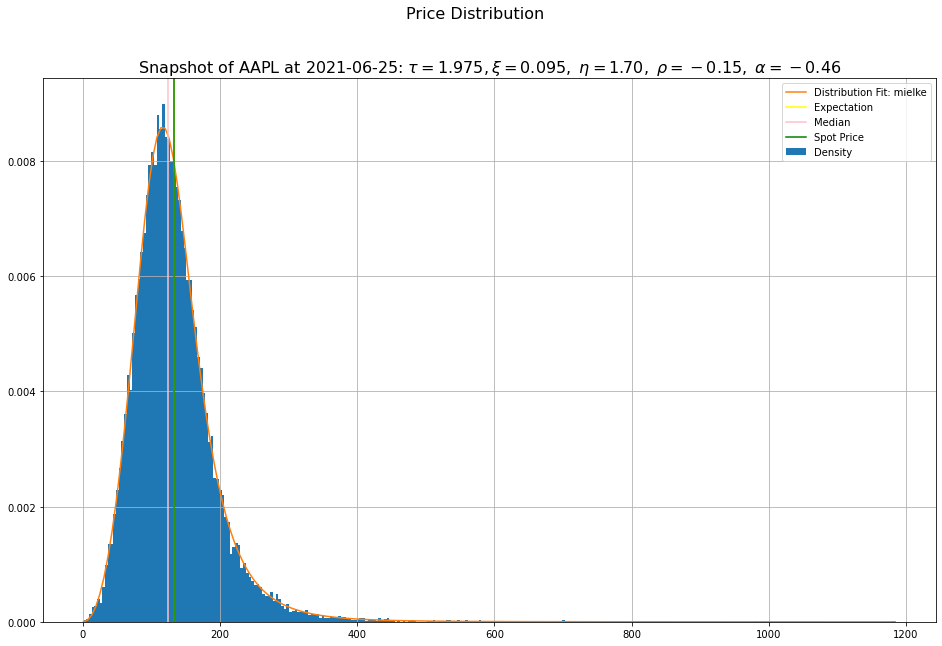

In [27]:
"""
Plotting Price Distribution

"""

plt.figure(figsize=(16,10))

plt.hist(FT, bins=300, density=True, label="Density")
plt.plot(x,y_best, label="Distribution Fit: {}".format(best_dist.name))
plt.axvline(x = np.mean(FT), color="yellow", label="Expectation") 
plt.axvline(x = np.median(FT), color="pink", label="Median")
plt.axvline(x = spot, color="green", label="Spot Price")
plt.suptitle("Price Distribution", fontsize=16)
title = r'Snapshot of {} at {}: $ \tau=%.3f, \xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'.format("AAPL", date_str)
plt.title(title%(tau, rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid()
plt.legend()
plt.show()

In [43]:
"""
Calculating Probability of Moneyness

"""
prob_moneyness_df = pd.DataFrame(index=df_last_mat["Strike"].values)
cdf_strikes = best_dist.cdf(df_last_mat["Strike"].values, loc=loc_best,scale=scale_best, *arg_best)
prob_moneyness_df["Probability of Moneyness in %"] = np.round((1-cdf_strikes)*100,2)
print(r"Probability of Moneyness for each given Strike and Maturity {} years".format(tau))
prob_moneyness_df

Probability of Moneyness for each given Strike and Maturity 1.975 years


,Probability of Moneyness in %
60.0,93.76
65.0,91.98
70.0,89.89
75.0,87.49
80.0,84.78
85.0,81.74
90.0,78.41
95.0,74.80
100.0,70.94
105.0,66.89


# Fit for all available Maturities

In [44]:
"""
# Showing all available Maturities

"""
df_cleaned["Tau"].unique()

array([0.019, 0.038, 0.058, 0.077, 0.096, 0.153, 0.23 , 0.307, 0.403,
       0.479, 0.575, 0.978, 1.227, 1.573, 1.726, 1.975])

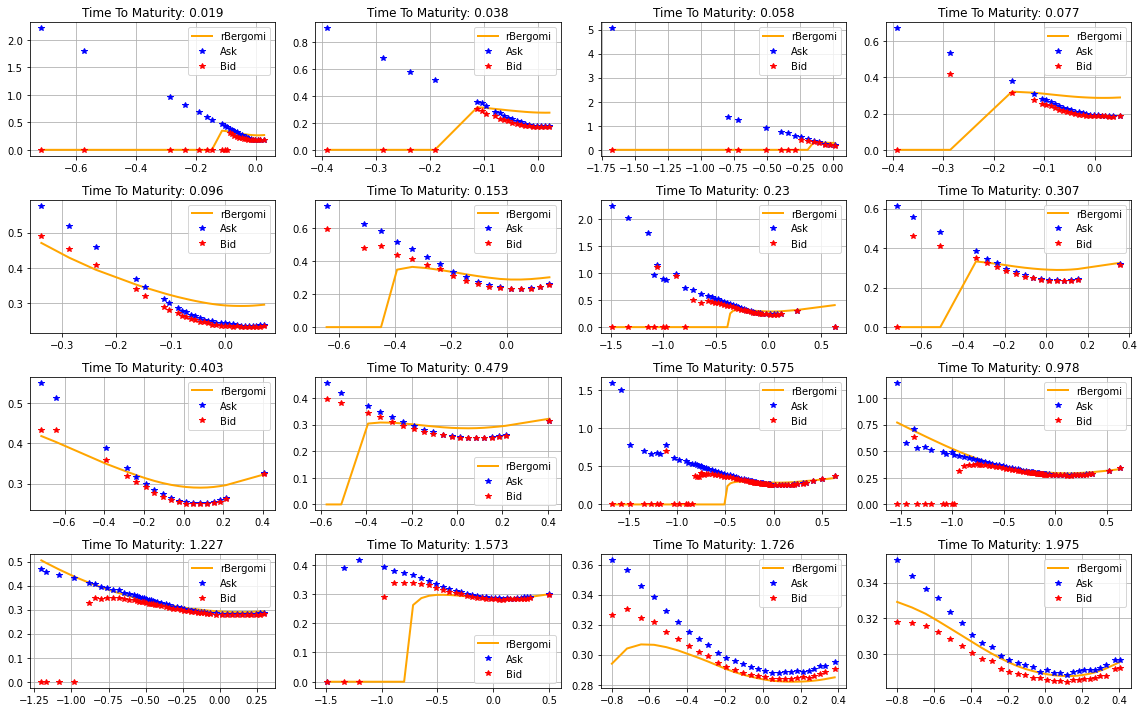

In [45]:
"""
Here we plot the full option chain for initial (manually calibrated) parameters

"""

plt.figure(figsize=(16,10))
j = -1
for i, tau in enumerate(df_cleaned["Tau"].unique()):
    j = j + 1
    plt.subplot(4,4,j+1)
    
    # Singling out slice of Dataframe based on time to maturity
    df_timeslice = df_cleaned[df_cleaned["Tau"] == tau]
    
    # Calculating Forward Price
    forward = df_timeslice["Fwd"].values[0]
    
    # calc rBergomi IVs
    rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, params_2)
    
    # Calculating log-strike
    logstrike = df_timeslice["Log Strike"].values
    
    # Calculating bid/ask bounds
    ask_iv_vals = df_timeslice["Ask IVs"].values 
    bid_iv_vals = df_timeslice["Bid IVs"].values 
    
    # Plotting the IV bid/ask bounds + rbergomi vals
    plt.plot(logstrike, rBivs, lw=2, c="orange", label="rBergomi")
    plt.plot(logstrike, ask_iv_vals, '*', c="b", label='Ask')
    plt.plot(logstrike, bid_iv_vals, '*', c="r", label='Bid')
    plt.title("Time To Maturity: {}".format(tau))
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

# Calibration Functions

In [46]:
def rBergomi_vols(df, params, opt_slice=None):
    """
    input:
    df = dataframe with option data
    params = rBergomi parameters
    opt_slice = optimization slice, defining a slice of the df to be used
    
    output:
    rB_list =  rBergomi implied Volatilities
    
    This function is able to price multiple option chains
    """
    
    if opt_slice is not None:
        print("Optimization slice given")
        df = df[df["Maturity"].isin(opt_slice)]
    
    exp_dates_list = df["Tau"].unique()
    
    print(dt.now())
    
    
    FT_list = list()
    call_prices_list = list()
    rB_list = list()
    
    for i, tau in enumerate(exp_dates_list):
        
        df_slice = df[df["Tau"]==tau]
        forward = df_slice["Fwd"].values[0]
        rBivs, c0, rB, FT = rbergomi_s(forward, df_slice["Strike"].values, tau, params)

        FT_list = [*FT_list, *np.squeeze(FT)]
        call_prices_list = [*call_prices_list, *np.squeeze(c0)]
        rB_list = [*rB_list, *np.squeeze(rBivs)]

    print(dt.now())
    print("---")
    return rB_list, df

In [47]:
"""
# select contracts to be used in optimisation
# Here we select the most crucial contracts to reduce optimization time.
# In order to strike a balance, we want to optimize for both the closest 
# and farthest from maturity.  

"""
expiration_dates = df_cleaned["Maturity"].unique()
mid_point = int(np.round(len(expiration_dates)/2))
optimization_slice = expiration_dates[[-1]]#, 1, mid_point, -2, -1]]
print("The Dates used for optimization are: ")
print(optimization_slice)

The Dates used for optimization are: 
['June 16, 2023']


In [48]:
def objective_fun(params):
    """
    Input:
    params =  rBergomi Parameters
    
    Output = MSE between the rBergomi vols given by params and
            respective mid-price IVs
    """
    
    rBerg_vols, df = rBergomi_vols(df_cleaned, params, opt_slice=optimization_slice)
    mid_vols = df["Mid IVs"].values
    MSE = np.mean((np.power(np.array(rBerg_vols) - np.array(mid_vols), 2)))
    return MSE

In [49]:
init_params = params_2
MSE_init = objective_fun(init_params)
print("The initial MSE for manual selected Params is: {}".format(MSE_init))

Optimization slice given
2021-09-27 14:09:57.548871
2021-09-27 14:10:01.883501
---
The initial MSE for manual selected Params is: 4.785638471488906e-06


# Running the Calibration

## Nelder Mead

In [50]:
Results = scipy.optimize.minimize(objective_fun, x0=init_params, method="Nelder-Mead", bounds=[[-0.0001,1.,-0.05,0.05],[-0.4999999,5,-1,1]], tol=0.001, options={'maxiter': 500, 'disp': True, 'maxfev': None})

C:\Users\Borsti\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


Optimization slice given
2021-09-27 14:10:50.204392
2021-09-27 14:10:54.391201
---
Optimization slice given
2021-09-27 14:10:54.393258
2021-09-27 14:10:58.474359
---
Optimization slice given
2021-09-27 14:10:58.476353
2021-09-27 14:11:02.622266
---
Optimization slice given
2021-09-27 14:11:02.625259
2021-09-27 14:11:06.735269
---
Optimization slice given
2021-09-27 14:11:06.737263
2021-09-27 14:11:10.832313
---
Optimization slice given
2021-09-27 14:11:10.835305
2021-09-27 14:11:14.908413
---
Optimization slice given
2021-09-27 14:11:14.910408
2021-09-27 14:11:18.923674
---
Optimization slice given
2021-09-27 14:11:18.925669
2021-09-27 14:11:22.874138
---
Optimization slice given
2021-09-27 14:11:22.876132
2021-09-27 14:11:26.846554
---
Optimization slice given
2021-09-27 14:11:26.848549
2021-09-27 14:11:30.879769
---
Optimization slice given
2021-09-27 14:11:30.881733
2021-09-27 14:11:34.903010
---
Optimization slice given
2021-09-27 14:11:34.904974
2021-09-27 14:11:38.936159
---
Opti

In [51]:
# Print Results
print("The initial Parameters were: {}".format(init_params))
print("The Nelder-Mead calibrated Parameters are: {}".format(Results.x))
print("The Nelder-Mead calibrated MSE is: {}".format(Results.fun))

# Runtime
start=dt.fromisoformat("2021-09-24 22:05:19.701803")
end=dt.fromisoformat("2021-09-24 22:17:55.452111")
delta_seconds = (end-start).total_seconds()
delta_mins = int(delta_seconds//60)
remaining = np.round(delta_seconds%60, 2)
print("Runtime was: {}:{} Minutes".format(delta_mins, remaining))

The initial Parameters were: (-0.46, 1.7, -0.15, 0.095481)
The Nelder-Mead calibrated Parameters are: [-0.46006768  1.82672824 -0.14831442  0.09617495]
The Nelder-Mead calibrated MSE is: 9.852482304068534e-07
Runtime was: 12:35.75 Minutes


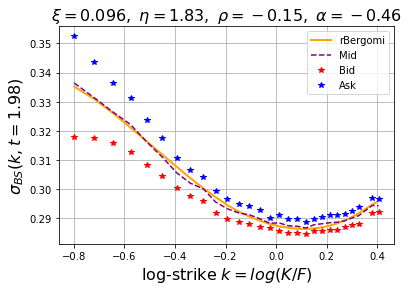

In [54]:
# Calculating log-strike
strike = df_timeslice["Strike"].values
logstrike = df_timeslice["Log Strike"].values

bid_iv_array = df_timeslice["Bid IVs"].values
ask_iv_array = df_timeslice["Ask IVs"].values
mid_vols = df_timeslice["Mid IVs"].values

forward = df_timeslice["Fwd"].values[0]
tau = df_timeslice["Tau"].values[0]

# Plotting the Fit
rBivs, c0, rB, FT = rbergomi_s(forward, strike, tau, Results.x)


# Graphing
plot, axes = plt.subplots()
axes.plot(logstrike,rBivs, lw=2, c="orange", label="rBergomi")
#axes.plot(log_strike, implied_vols_orig_data, lw=2, alpha=0.6, c="purple", label="Original Data")
axes.plot(logstrike,mid_vols, "--", c="purple", label = "Mid")
axes.plot(logstrike,bid_iv_array, "*", c="r", label = "Bid")
axes.plot(logstrike,ask_iv_array, "*", c="b", label="Ask")
#axes.plot(k_obs[idxT],iv_fit[idxT],'--g',label='Fit')
axes.legend()
axes.set_xlabel(r'log-strike $k=log(K/F)$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)

## Levenberg Marquardt

In [55]:
optimization_slice

array(['June 16, 2023'], dtype=object)

In [57]:
def objective_fun(params):
    """
    Input:
    params =  rBergomi Parameters
    
    Output = MSE between the rBergomi vols given by params and
            respective mid-price IVs
    Here we optimize on the slice of last expiration
    """
    
    rBerg_vols, df = rBergomi_vols(df_cleaned, params, opt_slice=optimization_slice)
    mid_vols = df["Mid IVs"].values
    MSE = np.mean((np.power(np.array(rBerg_vols) - np.array(mid_vols), 2)))
    return MSE

#Results_LM = scipy.optimize.minimize(objective_fun, x0=init_params, method="Nelder-Mead", bounds=[[-0.0001,1.,-0.05,0.05],[-0.5,5,-1,1]], tol=0.001, options={'maxiter': 500, 'disp': True, 'maxfev': None})

In [58]:
Results_trf = scipy.optimize.least_squares(objective_fun, init_params, jac='2-point', gtol=1E-10)

Optimization slice given
2021-09-27 14:43:42.725242
2021-09-27 14:43:47.028761
---
Optimization slice given
2021-09-27 14:43:47.030769
2021-09-27 14:43:51.170861
---
Optimization slice given
2021-09-27 14:43:51.172850
2021-09-27 14:43:55.479059
---
Optimization slice given
2021-09-27 14:43:55.481070
2021-09-27 14:43:59.953169
---
Optimization slice given
2021-09-27 14:43:59.956199
2021-09-27 14:44:04.325504
---
Optimization slice given
2021-09-27 14:44:04.337445
2021-09-27 14:44:08.548726
---
Optimization slice given
2021-09-27 14:44:08.550721
2021-09-27 14:44:12.832599
---
Optimization slice given
2021-09-27 14:44:12.834562
2021-09-27 14:44:17.141026
---
Optimization slice given
2021-09-27 14:44:17.143040
2021-09-27 14:44:21.413651
---
Optimization slice given
2021-09-27 14:44:21.416616
2021-09-27 14:44:25.534603
---
Optimization slice given
2021-09-27 14:44:25.537596
2021-09-27 14:44:29.668548
---
Optimization slice given
2021-09-27 14:44:29.670543
2021-09-27 14:44:33.868354
---
Opti

In [60]:
# Print Results
print("The initial Parameters were: {}".format(init_params))
print("The Levenberg Marquardt calibrated Parameters are: {}".format(Results_trf.x))
print("The Levenberg Marquardt calibrated MSE is: {}".format(Results_trf.fun))

# Runtime
import datetime as datetime
from datetime import datetime as dt
start=dt.fromisoformat("2021-09-25 20:01:17.501346")
end=dt.fromisoformat("2021-09-25 20:19:58.704318")
delta_seconds = (end-start).total_seconds()
delta_mins = int(delta_seconds//60)
remaining = np.round(delta_seconds%60, 2)
print("Runtime was: {}:{} Minutes".format(delta_mins, remaining))

The initial Parameters were: (-0.46, 1.7, -0.15, 0.095481)
The Levenberg Marquardt calibrated Parameters are: [-0.45381353  1.70037476 -0.15073544  0.09606013]
The Levenberg Marquardt calibrated MSE is: [1.07842991e-06]
Runtime was: 18:41.2 Minutes


In [201]:
-0.45381353,  1.70037476, -0.15073544,  0.09606013

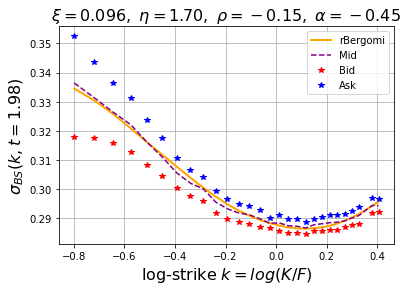

In [61]:
df_last_exp = df_cleaned[df_cleaned["Tau"]==1.975]
tau = df_last_exp["Tau"].values[-1]

# Calculating log-strike
strike = df_last_exp["Strike"].values
logstrike = df_last_exp["Log Strike"]

bid_iv_array = df_last_exp["Bid IVs"] 
ask_iv_array = df_last_exp["Ask IVs"] 
mid_vols = df_last_exp["Mid IVs"]

# Plotting the Fit
forward = df_last_exp["Fwd"].values[0]
tau = df_last_exp["Tau"].values[0]
forward = forward_price(spot, div, r, tau)
rBivs, c0, rB, FT = rbergomi_s(forward, strike, tau, Results_trf.x)


# Graphing
plot, axes = plt.subplots()
axes.plot(logstrike,rBivs, lw=2, c="orange", label="rBergomi")
#axes.plot(log_strike, implied_vols_orig_data, lw=2, alpha=0.6, c="purple", label="Original Data")
axes.plot(logstrike,mid_vols, "--", c="purple", label = "Mid")
axes.plot(logstrike,bid_iv_array, "*", c="r", label = "Bid")
axes.plot(logstrike,ask_iv_array, "*", c="b", label="Ask")
#axes.plot(k_obs[idxT],iv_fit[idxT],'--g',label='Fit')
axes.legend()
axes.set_xlabel(r'log-strike $k=log(K/F)$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)

# Calibration to the whole Vola Surface

## Nelder Mead

In [63]:
import datetime as datetime
from datetime import datetime as dt
# select contracts to be used in optimisation
# Here we select the most crucial contracts to reduce optimization time.
# In order to strike a balance, we want to optimize for both the closest 
# and farthest from maturity.  
expiration_dates = df_cleaned["Maturity"].unique()
mid_point = int(np.round(len(expiration_dates)/2))
optimization_slice = expiration_dates[[0, 2, 5, 12, -1]]#, 1, mid_point, -2, -1]]
print("The Dates used for optimization are: ")
print(optimization_slice)

The Dates used for optimization are: 
['July 2, 2021' 'July 16, 2021' 'August 20, 2021' 'September 16, 2022'
 'June 16, 2023']


In [122]:
"""
This here is the MSE for the full vola surface, using the initial parameters
"""

def objective_fun(params):
    """
    Input:
    params =  rBergomi Parameters
    
    Output = MSE between the rBergomi vols given by params and
            respective mid-price IVs
    """
    
    rBerg_vols, df = rBergomi_vols(df_cleaned, params, opt_slice=None)
    mid_vols = df["Mid IVs"].values
    MSE = np.mean((np.power(np.array(rBerg_vols) - np.array(mid_vols), 2)))
    return MSE

init_params = params_2
MSE_init = objective_fun(init_params)
print("The initial MSE of the full Vola Surface for manual selected Params is: {}".format(MSE_init))

2021-09-27 20:28:02.688294
2021-09-27 20:28:24.014295
---
The initial MSE of the full Vola Surface for manual selected Params is: 0.0937850062261301


In [ ]:
init_params = params_2
MSE_init = objective_fun(init_params)
print("The initial MSE of the full Vola Surface for manual selected Params is: {}".format(MSE_init))

In [121]:
"""
This here is the MSE we want to optimize for, it also gives the MSE
on the slice for the initial parameters
"""

def objective_fun(params):
    """
    Input:
    params =  rBergomi Parameters
    
    Output = MSE between the rBergomi vols given by params and
            respective mid-price IVs
    """
    
    rBerg_vols, df = rBergomi_vols(df_cleaned, params, opt_slice=optimization_slice)
    mid_vols = df["Mid IVs"].values
    MSE = np.mean((np.power(np.array(rBerg_vols) - np.array(mid_vols), 2)))
    return MSE

init_params = params_2

MSE_init = objective_fun(init_params)
print("The initial MSE of the slice we optimize for using manual selected Params is: {}".format(MSE_init))

Optimization slice given
2021-09-27 20:27:42.230144
2021-09-27 20:27:49.885701
---
The initial MSE of the slice we optimize for using manual selected Params is: 0.1652564942037492


In [130]:
Results_NM = scipy.optimize.minimize(objective_fun, x0=init_params, method="Nelder-Mead", bounds=[[-0.0001,1.,-0.05,0.05],[-0.5,5,-1,1]], tol=0.001, options={'maxiter': 500, 'disp': True, 'maxfev': None})

C:\Users\Borsti\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


2021-09-28 13:54:51.364683
2021-09-28 13:55:12.237931
---
2021-09-28 13:55:12.252854
2021-09-28 13:55:32.435918
---
2021-09-28 13:55:32.449814
2021-09-28 13:55:54.893796
---
2021-09-28 13:55:54.911749
2021-09-28 13:56:20.501773
---
2021-09-28 13:56:20.518077
2021-09-28 13:56:44.703311
---
2021-09-28 13:56:44.718280
2021-09-28 13:57:10.939455
---
2021-09-28 13:57:10.953652
2021-09-28 13:57:33.854014
---
2021-09-28 13:57:33.868452
2021-09-28 13:57:57.963455
---
2021-09-28 13:57:57.976421
2021-09-28 13:58:21.871847
---
2021-09-28 13:58:21.887736
2021-09-28 13:58:44.148053
---
2021-09-28 13:58:44.160988
2021-09-28 13:59:07.118923
---
2021-09-28 13:59:07.135808
2021-09-28 13:59:30.856606
---
2021-09-28 13:59:30.869571
2021-09-28 13:59:55.648812
---
2021-09-28 13:59:55.662708
2021-09-28 14:00:16.841140
---
2021-09-28 14:00:16.854105
2021-09-28 14:00:37.598632
---
2021-09-28 14:00:37.611597
2021-09-28 14:00:58.076804
---
2021-09-28 14:00:58.089769
2021-09-28 14:01:18.607900
---
2021-09-28 14:

In [138]:
# Print Results
print("Fit to the full Implied Volatility Surface using Nelder Mead")
print("The initial Parameters were: {}".format(init_params))
print("The slice optimized is: {}".format(optimization_slice))
print("The Nelder Mead calibrated Parameters are: {}".format(Results_NM.x))
print("The Nelder Mead calibrated MSE is: {}".format(Results_NM.fun))

# Runtime
start=dt.fromisoformat("2021-09-28 13:54:51.364683")
end=dt.fromisoformat("2021-09-28 15:14:10.211126")
delta_seconds = (end-start).total_seconds()
delta_mins = int(delta_seconds//60)
remaining = np.round(delta_seconds%60, 2)
print("Runtime was: {}:{} Minutes".format(delta_mins, remaining))

best_params = (-0.49999999, 0.83515963, -0.93144967, 0.06974231)
best_fit_result = objective_fun(best_params)
print("Best Parameters found are: {}".format(best_params))
print("These provide an MSE of {}".format(best_fit_result))

Fit to the full Implied Volatility Surface using Nelder Mead
The initial Parameters were: (-0.46, 1.7, -0.15, 0.095481)
The slice optimized is: ['July 2, 2021' 'July 16, 2021' 'August 20, 2021' 'September 16, 2022'
 'June 16, 2023']
The Nelder Mead calibrated Parameters are: [-0.38901846  3.70744805 -0.02503472  0.08063469]
The Nelder Mead calibrated MSE is: 0.0361283015667375
Runtime was: 79:18.85 Minutes
2021-09-28 15:24:57.380468
2021-09-28 15:25:19.294932
---
Best Parameters found are: (-0.49999999, 0.83515963, -0.93144967, 0.06974231)
These provide an MSE of 0.003014821234816511


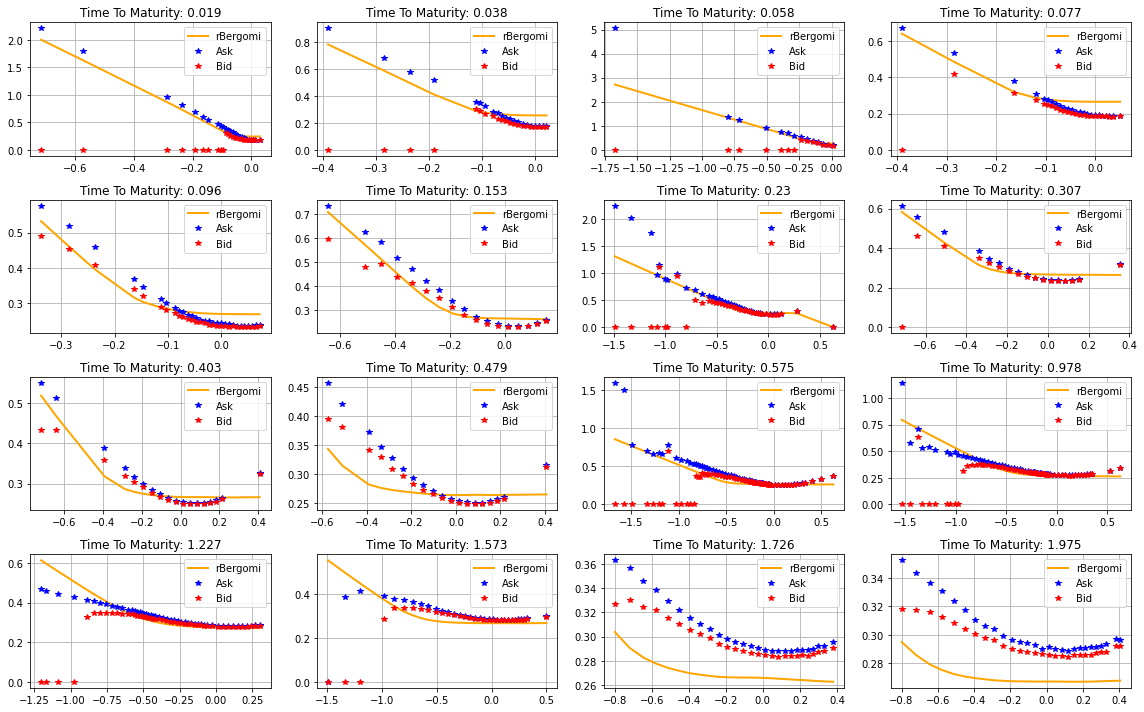

In [139]:
# Fit For Best Params
plt.figure(figsize=(16,10))
j = -1
for i, tau in enumerate(df_cleaned["Tau"].unique()):
    j = j + 1
    plt.subplot(4,4,j+1)
    
    # Singling out slice of Dataframe based on time to maturity
    df_timeslice = df_cleaned[df_cleaned["Tau"] == tau]
    
    # Calculating Forward Price
    forward = forward_price(spot, div, r, tau)
    
    # calc rBergomi IVs
    rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, best_params)
    
    # Calculating log-strike
    logstrike = np.log(df_timeslice["Strike"].values/forward)
    
    # Calculating bid/ask bounds
    ask_iv_vals = vec_bsinv(df_timeslice["Ask"].values, forward, df_timeslice["Strike"].values, tau)
    bid_iv_vals = vec_bsinv(df_timeslice["Bid"].values, forward, df_timeslice["Strike"].values, tau)
    
    # Plotting the IV bid/ask bounds + rbergomi vals
    plt.plot(logstrike, rBivs, lw=2, c="orange", label="rBergomi")
    plt.plot(logstrike, ask_iv_vals, '*', c="b", label='Ask')
    plt.plot(logstrike, bid_iv_vals, '*', c="r", label='Bid')
    plt.title("Time To Maturity: {}".format(tau))
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

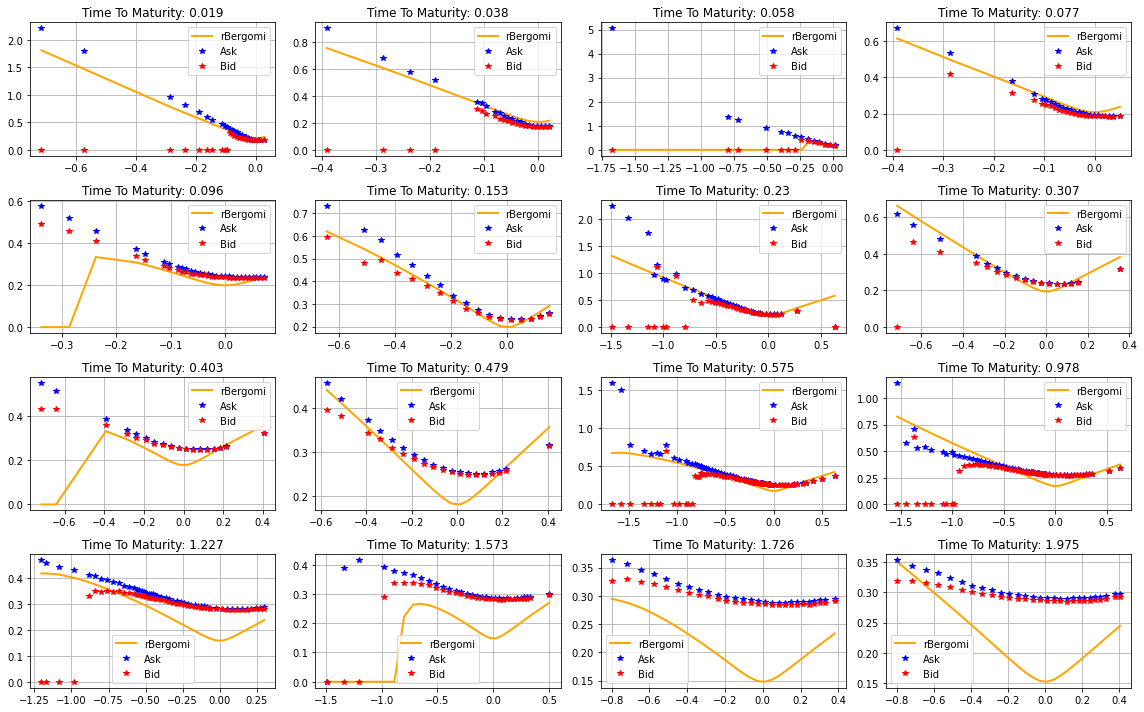

In [140]:
# FIt for other params found: 
plt.figure(figsize=(16,10))
j = -1
for i, tau in enumerate(df_cleaned["Tau"].unique()):
    j = j + 1
    plt.subplot(4,4,j+1)
    
    # Singling out slice of Dataframe based on time to maturity
    df_timeslice = df_cleaned[df_cleaned["Tau"] == tau]
    
    # Calculating Forward Price
    forward = forward_price(spot, div, r, tau)
    
    # calc rBergomi IVs
    rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, Results_NM.x)
    
    # Calculating log-strike
    logstrike = np.log(df_timeslice["Strike"].values/forward)
    
    # Calculating bid/ask bounds
    ask_iv_vals = vec_bsinv(df_timeslice["Ask"].values, forward, df_timeslice["Strike"].values, tau)
    bid_iv_vals = vec_bsinv(df_timeslice["Bid"].values, forward, df_timeslice["Strike"].values, tau)
    
    # Plotting the IV bid/ask bounds + rbergomi vals
    plt.plot(logstrike, rBivs, lw=2, c="orange", label="rBergomi")
    plt.plot(logstrike, ask_iv_vals, '*', c="b", label='Ask')
    plt.plot(logstrike, bid_iv_vals, '*', c="r", label='Bid')
    plt.title("Time To Maturity: {}".format(tau))
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

## The Levenberg-Marquardt Minimizer

In [ ]:
-0.45381353,  1.70037476, -0.15073544,  0.09606013

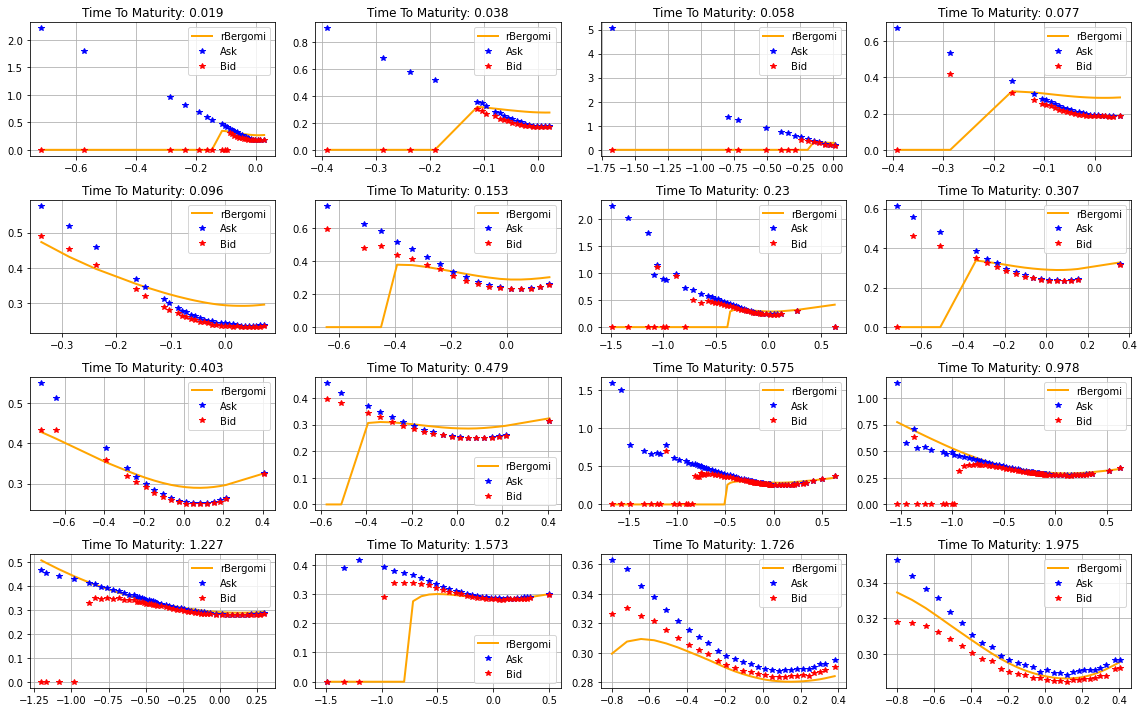

In [144]:
# FIt for other params found: 
plt.figure(figsize=(16,10))
j = -1
for i, tau in enumerate(df_cleaned["Tau"].unique()):
    j = j + 1
    plt.subplot(4,4,j+1)
    
    # Singling out slice of Dataframe based on time to maturity
    df_timeslice = df_cleaned[df_cleaned["Tau"] == tau]
    
    # Calculating Forward Price
    forward = forward_price(spot, div, r, tau)
    
    # calc rBergomi IVs
    xyz = (-0.45381353,  1.70037476, -0.15073544,  0.09606013)
    rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, xyz)
    
    # Calculating log-strike
    logstrike = np.log(df_timeslice["Strike"].values/forward)
    
    # Calculating bid/ask bounds
    ask_iv_vals = vec_bsinv(df_timeslice["Ask"].values, forward, df_timeslice["Strike"].values, tau)
    bid_iv_vals = vec_bsinv(df_timeslice["Bid"].values, forward, df_timeslice["Strike"].values, tau)
    
    # Plotting the IV bid/ask bounds + rbergomi vals
    plt.plot(logstrike, rBivs, lw=2, c="orange", label="rBergomi")
    plt.plot(logstrike, ask_iv_vals, '*', c="b", label='Ask')
    plt.plot(logstrike, bid_iv_vals, '*', c="r", label='Bid')
    plt.title("Time To Maturity: {}".format(tau))
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

In [143]:
Results_trf.fun

array([1.07842991e-06])

In [190]:
Results_trf2 = scipy.optimize.least_squares(objective_fun, init_params, gtol=0.00001)#gtol=1E-10

Optimization slice given
2021-09-29 18:58:58.779060
2021-09-29 18:59:06.728125
---
Optimization slice given
2021-09-29 18:59:06.734040
2021-09-29 18:59:14.724496
---
Optimization slice given
2021-09-29 18:59:14.731477
2021-09-29 18:59:22.822522
---
Optimization slice given
2021-09-29 18:59:22.828498
2021-09-29 18:59:30.101115
---
Optimization slice given
2021-09-29 18:59:30.106064
2021-09-29 18:59:37.493347
---
Optimization slice given
2021-09-29 18:59:37.499301
2021-09-29 18:59:45.937700
---
Optimization slice given
2021-09-29 18:59:45.943684
2021-09-29 18:59:54.386108
---
Optimization slice given
2021-09-29 18:59:54.391095
2021-09-29 19:00:02.832522
---
Optimization slice given
2021-09-29 19:00:02.837509
2021-09-29 19:00:10.238193
---
Optimization slice given
2021-09-29 19:00:10.243152
2021-09-29 19:00:17.545610
---
Optimization slice given
2021-09-29 19:00:17.550572
2021-09-29 19:00:24.985760
---
Optimization slice given
2021-09-29 19:00:24.991078
2021-09-29 19:00:32.233757
---
Opti

In [188]:
Results_trf2

 active_mask: array([0., 0., 0., 0.])
        cost: 0.012553915519129924
         fun: array([0.15845451])
        grad: array([-1.21412037e-03,  7.29948407e-05,  7.23550924e-04, -6.73673270e-03])
         jac: array([[-0.00766226,  0.00046067,  0.0045663 , -0.04251525]])
     message: 'Both `ftol` and `xtol` termination conditions are satisfied.'
        nfev: 45
        njev: 22
  optimality: 0.0067367327048575044
      status: 4
     success: True
           x: array([-0.41436948,  1.70114322, -0.16172928,  0.07606519])

In [175]:
def objective_fun_full_surface(params):
    """
    Input:
    params =  rBergomi Parameters
    
    Output = MSE between the rBergomi vols given by params and
            respective mid-price IVs
    """
    
    rBerg_vols, df = rBergomi_vols(df_cleaned, params, opt_slice=None)
    mid_vols = df["Mid IVs"].values
    print("Len of mid vols")
    print(len(mid_vols))
    MSE = np.mean((np.power(np.array(rBerg_vols) - np.array(mid_vols), 2)))
    return MSE

In [177]:
"""
This here is the MSE for the full vola surface, using the initial parameters
"""

def objective_fun(params):
    """
    Input:
    params =  rBergomi Parameters
    
    Output = MSE between the rBergomi vols given by params and
            respective mid-price IVs
    """
    
    rBerg_vols, df = rBergomi_vols(df_cleaned, params, opt_slice=optimization_slice)
    mid_vols = df["Mid IVs"].values
    MSE = np.mean((np.power(np.array(rBerg_vols) - np.array(mid_vols), 2)))
    return MSE

In [191]:
# Print Results
print("Fit to the full Implied Volatility Surface using Nelder Mead")
print("The initial Parameters were: {}".format(init_params))
print("The slice optimized is: {}".format(optimization_slice))
print("The Levenberg Marquardt calibrated Parameters are: {}".format(Results_trf2.x))
print("The Levenberg Marquardt calibrated MSE is: {}".format(Results_trf2.fun))

# Runtime
start=dt.fromisoformat("2021-09-29 17:20:21.048871")
end=dt.fromisoformat("2021-09-29 17:37:12.361059")
delta_seconds = (end-start).total_seconds()
delta_mins = int(delta_seconds//60)
remaining = np.round(delta_seconds%60, 2)
print("Runtime was: {}:{} Minutes".format(delta_mins, remaining))

best_params = Results_trf2.x
best_fit_result = objective_fun(best_params)
print("Best Parameters found by LM are: {}".format(best_params))
print("These provide an MSE of {} for the optimization slice".format(best_fit_result))
best_fit_result_full_surface = objective_fun_full_surface(best_params)
print("These provide an MSE of {} for the full surface".format(best_fit_result_full_surface))

Fit to the full Implied Volatility Surface using Nelder Mead
The initial Parameters were: (-0.46, 1.7, -0.15, 0.095481)
The slice optimized is: ['July 2, 2021' 'July 16, 2021' 'August 20, 2021' 'September 16, 2022'
 'June 16, 2023']
The Levenberg Marquardt calibrated Parameters are: [-0.41436948  1.70114322 -0.16172928  0.07606519]
The Levenberg Marquardt calibrated MSE is: [0.15845451]
Runtime was: 16:51.31 Minutes
Optimization slice given
2021-09-29 20:33:19.790266
2021-09-29 20:33:27.451778
---
Best Parameters found by LM are: [-0.41436948  1.70114322 -0.16172928  0.07606519]
These provide an MSE of 0.15845450778775544 for the optimization slice
2021-09-29 20:33:27.455768
2021-09-29 20:33:48.437753
---
Len of mid vols
492
These provide an MSE of 0.09065445510597507 for the full surface


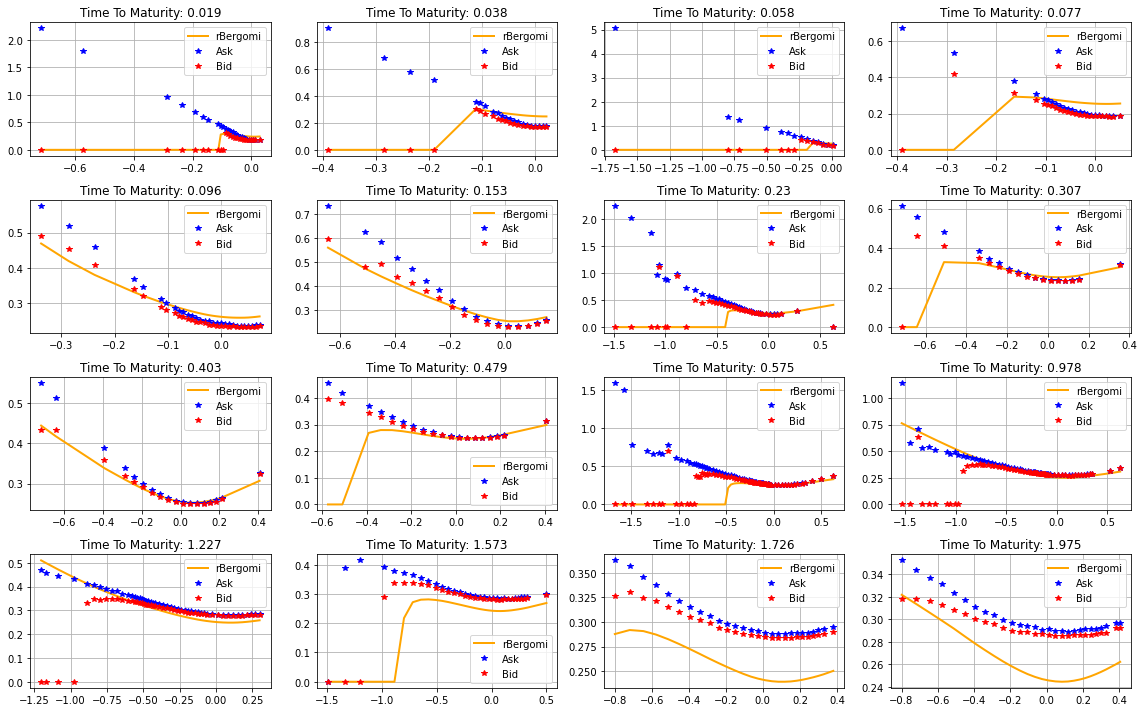

In [186]:
# FIt for other params found: 
plt.figure(figsize=(16,10))
j = -1
for i, tau in enumerate(df_cleaned["Tau"].unique()):
    j = j + 1
    plt.subplot(4,4,j+1)
    
    # Singling out slice of Dataframe based on time to maturity
    df_timeslice = df_cleaned[df_cleaned["Tau"] == tau]
    
    # Calculating Forward Price
    forward = forward_price(spot, div, r, tau)
    
    # calc rBergomi IVs
    params_LM = (-0.41436948, 1.70114322, -0.16172928, 0.07606519)
    rBivs, c0, rB, FT = rbergomi_s(forward, df_timeslice["Strike"].values, tau, params_LM)
    
    # Calculating log-strike
    logstrike = np.log(df_timeslice["Strike"].values/forward)
    
    # Calculating bid/ask bounds
    ask_iv_vals = vec_bsinv(df_timeslice["Ask"].values, forward, df_timeslice["Strike"].values, tau)
    bid_iv_vals = vec_bsinv(df_timeslice["Bid"].values, forward, df_timeslice["Strike"].values, tau)
    
    # Plotting the IV bid/ask bounds + rbergomi vals
    plt.plot(logstrike, rBivs, lw=2, c="orange", label="rBergomi")
    plt.plot(logstrike, ask_iv_vals, '*', c="b", label='Ask')
    plt.plot(logstrike, bid_iv_vals, '*', c="r", label='Bid')
    plt.title("Time To Maturity: {}".format(tau))
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

# 3D Plot: Synthetic Volatility Surface

In [197]:
# Defining needed variables and parameters
spot=1.
strikes = np.arange(-2, 2, 0.1)
alpha = -0.35
eta = 2.5
rho = -0.7
xi = 0.15
params_3 = alpha, eta, rho, xi

texp_list = np.arange(0.002,3,0.1)
df_ivs = pd.DataFrame(columns=np.flip(texp_list), index=strikes)


# Generating associated IVs
for i, texp in enumerate(df_ivs.columns.values):
    ivs, c0, rB, FT = rbergomi_s(spot, strikes, texp, params_3) 
    ivs = np.squeeze(ivs)
    ivs[ivs==1.e-19] = np.nan
    df_ivs[texp] = ivs

ValueError: f(a) and f(b) must have different signs

In [196]:


# Restricting Surface to reasonable values
df_new =df_ivs[(df_ivs.index>-.6)&(df_ivs.index<1.2)]

# Plotting!
# Instantiate Plot
df = df_new
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=45., azim=-55)

# Assign Values to Axes
X = df.columns.values
Y = df.index #df_ivs.index.values
Y= np.flip(Y)
X, Y = np.meshgrid(X, Y)
Z = df.values.astype(dtype=np.float64) #np.sin(R)

# Plot ImpVolSurface
ax.plot_surface(X, Y, Z, alpha=0.9)
#max_vol = np.max(np.max(df_ivs))
#ax.set_zlim(0., max_vol*1.2)
ax.set_xlabel("Time to Maturity in Years")
ax.set_ylabel("Log-Strike Prices")
ax.set_zlabel('Implied Volatility')
#plt.title("{}".format(option_contract_df[0]))
plt.show()

ValueError: f(a) and f(b) must have different signs